# Aula 8

---

**Saulo Martiello Mastelini**<br>
Candidato a Ph.D. pelo ICMC-USP<br>
Online Machine Learning

Página pessoal: [smastelini](https://smastelini.github.io/)</br>
e-mail: saulomastelini@gmail.com

---

- Clustering particional
    - k-Means
    - DBSCAN
- Estratégias para avaliação
- Heurísticas para a escolha do número de clusters

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [2]:
%matplotlib inline

# Clustering (ou agrupamento)

- Tarefa de aprendizado não-supervisionado
    - Apenas `X`, sem `y`
    - Queremos encontrar padrões nos dados
    - Criar grupos cujos elementos são similares entre si
    
- Basicamente dois tipos de algoritmos de agrupamento:
    - Hierárquicos: cria uma estrutura em árvore onde a raiz contém todos os pontos e as folhas são pontos individuais
        - Podem ser construídos em abordagens _top-down_ ou _bottom-up_
        - Grupos são montados ao fazer um corte em um determinado nível da árvore
    - Particionais: os grupos são "_flat_"
        - Não possuem uma noção de hierarquia
        - Em geral, cada ponto pode pertencer a no máximo um grupo
            - Soft clustering, atribui uma probabilidade de pertença para cada grupo

# Plano

Nessa aula abordaremos basicamente dois algoritmos para clustering particional, que se baseiam em diferentes estratégias:

- Protótipo
    1. k-Means
    2. k-Medians
    3. Partitioning Around Medoids (PAM) ou k-Medoids
- Densidade
    4. DBSCAN
    
## Lembrete:

Apesar de alguns algoritmos de agrupamento oferecerem uma função `predict`, estamos falando de um paradigma descritivo de aprendizado, e não preditivo. É importante sempre nos lembrarmos das diferenças desse tipo de atividade em relação à tarefas de predição (aprendizado supervisionado).
 

# 1. Clustering Particional: protótipos

## 1.1. [k-Means](https://scikit-learn.org/stable/modules/clustering.html#k-means)

O k-Means busca separar os dados em grupos de igual variância. Para tal, o k-Means minimiza um critério conhecido como *Inertia* (inércia) ou *Within-cluster sum-of-squares*. É o equivalente a miminizar a distância euclidiana ao quadrado de cada ponto para o seu centróide ou, ainda, a variância intra-cluster ([leitura interessante](https://stats.stackexchange.com/questions/158210/k-means-why-minimizing-wcss-is-maximizing-distance-between-clusters)). A inércia mede quão coerentes os clusters são internamente. No entanto, temos alguns problemas com essa abordagem:

- A inércia assume que os clusters são convexos e isotrópicos (seus raios são iguais), o que nem sempre é verdade.
- A inércia não é uma métrica com *range* bem definido: apenas sabemos que quanto menor, melhor e, que zero é o valor mínimo possível. Em espaços com muitas dimensões, o uso da distância euclidiana pode nos levar a problemas devido à um [caso específico](https://stats.stackexchange.com/questions/99171/why-is-euclidean-distance-not-a-good-metric-in-high-dimensions) da [tão dita maldição da dimensionalidade](https://builtin.com/data-science/curse-dimensionality). Nesse caso, vale a pena utilizar um algoritmo para redução de dimensões, como a Análise de Componentes Principais (PCA), antes do k-Means (de bônus, reduzimos o tempo de computação).


Começarei definindo uma implementação simples desse algoritmo e depois avaliaremos o passo-a-passo de sua implementação.

In [3]:
class KMeans:
    def __init__(self, k, etol=1e-3, max_iter=100, random_state=42):
        self.k = k
        self.etol = etol
        self.max_iter = max_iter
        self.random_state = random_state
        
        # Define semente de geração aleatória
        np.random.seed(self.random_state)

        # Variáveis internas
        self.cluster_centers_ = None
        self.n_iter_ = 0  # Número de iterações
        
    
    def _clustering_criterion(self, X, cluster_center):
        # Within cluster sum-of-squares
        return np.sum((X - cluster_center) ** 2, axis=1)
    
    
    def _pick_centers(self, X, verbose=False):
        # Vou selecionar aleatoriamente k linhas dos meus dados para serem
        # os centros iniciais
        sel_rows = np.random.choice(X.shape[0], size=self.k, replace=False)
        
        if verbose:
            print('\nLinhas selecionadas como centros dos clusters:', sel_rows)
        
        self.cluster_centers_ = np.zeros((self.k, X.shape[1]))
        
        # Note que o "label" que cada centro recebe depende na seleção inicial
        # (não existe uma noção de ordem aqui)
        for cluster_id, row in enumerate(sel_rows):
            self.cluster_centers_[cluster_id] = X[row]
        
        if verbose:
            print('Centros selecionados:')
            for center_id, center in enumerate(self.cluster_centers_):
                print(f'{center_id}: {center}')
    
    def _update_centers(self, X, verbose=False):
        scores = self.predict(X)
        
        new_centers = np.zeros_like(self.cluster_centers_)
        
        for center_id in range(self.k):
            new_centers[center_id] = np.mean(X[scores == center_id], axis=0)
        
        if verbose:
            print('\nMudança dos centros:')
            for center_id in range(self.k):
                print(f'{center_id}: {self.cluster_centers_[center_id]} -> {new_centers[center_id]}')
                
        return new_centers
    
    def _stop_criteria_convergence(self, new_centers, verbose=False):
        diff = np.sum((self.cluster_centers_ - new_centers) ** 2)
        check = diff < self.etol
        
        if verbose:
            print(f'Variação dos centros: {diff}')
            if check:
                print(f'\nVariação dos centros é menor que "etol": {diff}. Parando.')
        return check
    
    def _stop_criteria_max_iter(self, verbose=False):
        check = self.n_iter_ >= self.max_iter
        
        if verbose:
            print(f'Iteração {self.n_iter_}')
            if check:
                print(f'\nNúmero máximo de iterações atingido: {self.n_iter_}. Parando.')
        return check
    
    def fit(self, X, verbose=False, cycle_callback=None):
        # Inicializa os centros
        self._pick_centers(X, verbose=verbose)
        
        p_out = None
        
        while True:  # Loop infinito. Os critérios de parada definirão o fim dos ciclos
            new_centers = self._update_centers(X, verbose=verbose)
            
            # Pequeno acochambramento
            if cycle_callback is not None:
                p_out = cycle_callback(X, self.predict(X), new_centers, fig=p_out)
            
            if self._stop_criteria_convergence(new_centers, verbose=verbose):
                break
            
            self.cluster_centers_ = new_centers
            
            # Pequeno acochambramento
            if cycle_callback is not None:
                p_out = cycle_callback(X, self.predict(X), self.cluster_centers_, fig=p_out)
            
            # Atualiza o número de iterações
            self.n_iter_ += 1
        
            if self._stop_criteria_max_iter(verbose=verbose):
                break
        
        return self
    
    def predict(self, X, verbose=False):
        # Matriz com n_instances x n_clusters
        errors = np.zeros((X.shape[0], self.k))
        
        for center_id, center in enumerate(self.cluster_centers_):
            errors[:, center_id] = self._clustering_criterion(X, center)
        
        if verbose:
            print(errors)
            
        return np.argmin(errors, axis=1)
        

###### Agora vamos aos poucos entender o papel de cada parte

### 1.1.1. A iniciar pela seleção dos centros

In [4]:
# Vou gerar uma matriz de numeros aleatórios
np.random.seed(7)
X_toy = np.random.uniform(size=(20, 2))

print('Dados:')
print(X_toy)

kmeans = KMeans(k=3)
kmeans._pick_centers(X_toy, verbose=True)

Dados:
[[0.07630829 0.77991879]
 [0.43840923 0.72346518]
 [0.97798951 0.53849587]
 [0.50112046 0.07205113]
 [0.26843898 0.4998825 ]
 [0.67923    0.80373904]
 [0.38094113 0.06593635]
 [0.2881456  0.90959353]
 [0.21338535 0.45212396]
 [0.93120602 0.02489923]
 [0.60054892 0.9501295 ]
 [0.23030288 0.54848992]
 [0.90912837 0.13316945]
 [0.52341258 0.75040986]
 [0.66901324 0.46775286]
 [0.20484909 0.49076589]
 [0.37238469 0.47740115]
 [0.36589039 0.83791799]
 [0.76864751 0.31399468]
 [0.57262533 0.27604905]]

Linhas selecionadas como centros dos clusters: [ 0 17 15]
Centros selecionados:
0: [0.07630829 0.77991879]
1: [0.36589039 0.83791799]
2: [0.20484909 0.49076589]


**Vou definir uma função simples de plot para não ficar repetindo código sem necessidade**

In [5]:
def plot_cluster(X, labels=None, centers=None, fig=None):
    # Figura começando do zero
    if fig is None:
        dims = (3, 3)  # Sem legenda
        if labels is not None:
            if centers is None:
                dims = (4, 4)  # Sem centros
            else:
                dims = (5, 3)  # Com centros
        
        fig, ax = plt.subplots(figsize=dims)
    else:  # Reciclando figura anterior
        ax = fig.axes[0]
    
    if labels is None:
        ax.scatter(X[:, 0], X[:, 1])
    else:
        for center in np.unique(labels):
            imask = labels == center
            ax.scatter(X[imask, 0], X[imask, 1], label=center)

        if centers is not None:
            ax.scatter(centers[:, 0], centers[:, 1], marker='+', c='black',
                       label='center', s=200)
        ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    plt.close()
    return fig

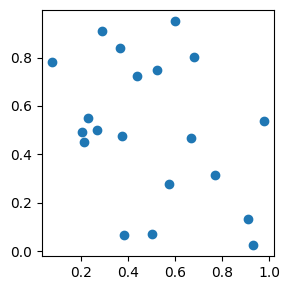

In [6]:
plot_cluster(X_toy)

### 1.1.2. Função predict

Notem que a as linhas escolhidas como centros iniciais tem inércia zero.

In [7]:
scores = kmeans.predict(X_toy, verbose=True)
print('\nScores:', scores)

[[0.         0.0872217  0.10013214]
 [0.1343041  0.01835843 0.1086993 ]
 [0.87131405 0.46431895 0.60002426]
 [0.68154201 0.60483922 0.26309877]
 [0.11533453 0.12376477 0.00412679]
 [0.36408199 0.09934991 0.32298943]
 [0.6025721  0.59618219 0.21148855]
 [0.06169058 0.01118163 0.1823549 ]
 [0.12623957 0.17209482 0.00156607]
 [1.30090467 0.98058128 0.74462614]
 [0.30379992 0.06765605 0.36759328]
 [0.07727366 0.10215258 0.00397996]
 [1.11187401 0.79177803 0.62388453]
 [0.20077302 0.03247092 0.16889769]
 [0.44874673 0.22890569 0.21597796]
 [0.10013214 0.14644888 0.        ]
 [0.17917816 0.13001457 0.02824679]
 [0.0872217  0.         0.14644888]
 [0.69641887 0.43670894 0.34911672]
 [0.50021533 0.35843605 0.18136269]]

Scores: [0 1 1 2 2 1 2 1 2 2 1 2 2 1 2 2 2 1 2 2]


Sem visualizar os centroides

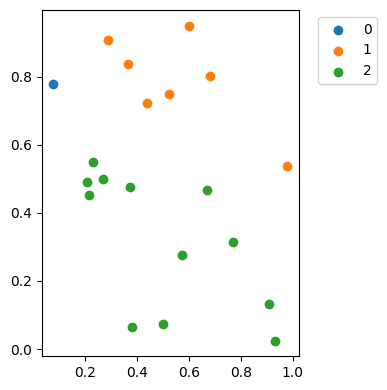

In [8]:
plot_cluster(X_toy, scores)

Com os centroides

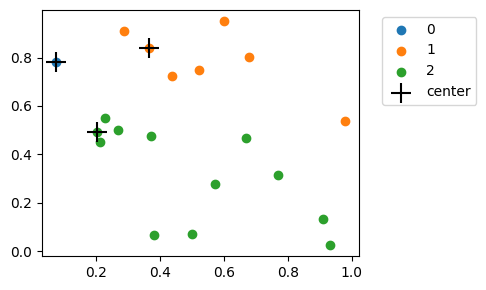

In [9]:
plot_cluster(X_toy, scores, kmeans.cluster_centers_)

### 1.1.3. Por fim, vamos testar a função que atualiza os centroides

In [10]:
new_centroids = kmeans._update_centers(X_toy, verbose=True)


Mudança dos centros:
0: [0.07630829 0.77991879] -> [0.07630829 0.77991879]
1: [0.36589039 0.83791799] -> [0.55337517 0.78767871]
2: [0.20484909 0.49076589] -> [0.50183692 0.31854301]


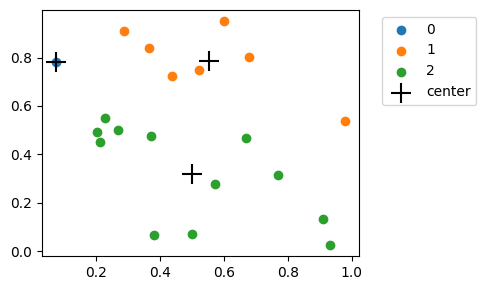

In [11]:
plot_cluster(X_toy, scores, new_centroids)

In [12]:
# Vou forçar a troca dos centroides
kmeans.cluster_centers_ = new_centroids
scores = kmeans.predict(X_toy)
print('\nScores:', scores)


Scores: [0 1 1 2 2 1 2 0 2 2 1 0 2 1 2 0 2 1 2 2]


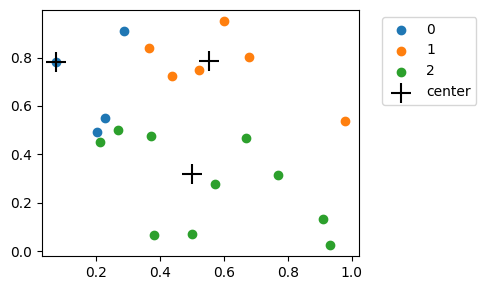

In [13]:
plot_cluster(X_toy, scores, kmeans.cluster_centers_)

### 1.1.4. Vamos avaliar nossos critérios de parada

In [14]:
kmeans.n_iter_ += 1
# Iterações (iteramos apenas uma vez)
kmeans._stop_criteria_max_iter(verbose=True)

Iteração 1


False

##### Let's try again: mais uma iteração

In [15]:
new_centroids = kmeans._update_centers(X_toy, verbose=True)


Mudança dos centros:
0: [0.07630829 0.77991879] -> [0.19990146 0.68219203]
1: [0.55337517 0.78767871] -> [0.5975801  0.76735957]
2: [0.50183692 0.31854301] -> [0.55868911 0.27832604]


In [16]:
kmeans.n_iter_ += 1
# Iterações (iteramos duas vezes)
kmeans._stop_criteria_max_iter(verbose=True)

Iteração 2


False

In [19]:
# Convergência
kmeans._stop_criteria_convergence(new_centroids, verbose=True)

Variação dos centros: 0.03204231220845901


False

In [20]:
# Vou atualizar mais uma vez os centroides de forma manual
kmeans.cluster_centers_ = new_centroids
scores = kmeans.predict(X_toy)
print('\nScores:', scores)


Scores: [0 1 1 2 0 1 2 0 0 2 1 0 2 1 2 0 0 0 2 2]


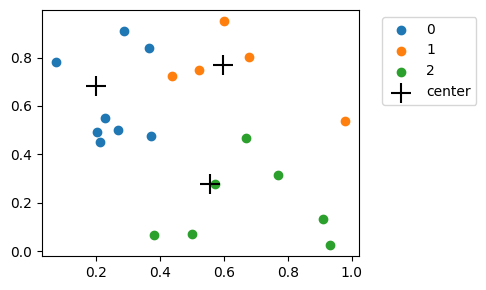

In [21]:
plot_cluster(X_toy, scores, kmeans.cluster_centers_)

E assim por diante...


##### E se mudarmos a inicialização?

In [22]:
kmeans = KMeans(k=3, random_state=0)
kmeans._pick_centers(X_toy, verbose=True)
scores = kmeans.predict(X_toy)
print('\nScores:', scores)


Linhas selecionadas como centros dos clusters: [18  1 19]
Centros selecionados:
0: [0.76864751 0.31399468]
1: [0.43840923 0.72346518]
2: [0.57262533 0.27604905]

Scores: [1 1 0 2 1 1 2 1 1 0 1 1 0 1 0 1 1 1 0 2]


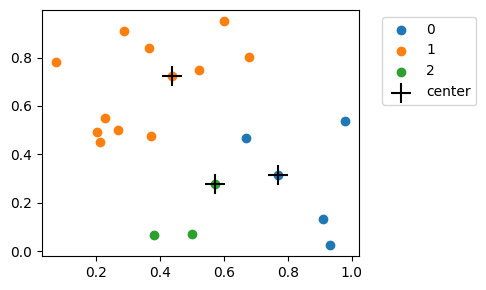

In [23]:
plot_cluster(X_toy, scores, kmeans.cluster_centers_)

In [24]:
new_centroids = kmeans._update_centers(X_toy, verbose=True)
kmeans.cluster_centers_ = new_centroids
scores = kmeans.predict(X_toy)
print('\nScores:', scores)


Mudança dos centros:
0: [0.76864751 0.31399468] -> [0.85119693 0.29566242]
1: [0.43840923 0.72346518] -> [0.35510883 0.68531978]
2: [0.57262533 0.27604905] -> [0.48489564 0.13801218]

Scores: [1 1 0 2 1 1 2 1 1 0 1 1 0 1 0 1 1 1 0 2]


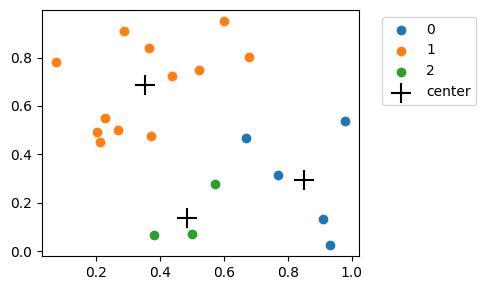

In [25]:
plot_cluster(X_toy, scores, kmeans.cluster_centers_)

A inicialização faz toda a diferença. A literatura nos traz formas mais "espertas" de se inicializar os clusters. Por exemplo, esse [artigo](http://people.eecs.berkeley.edu/~brecht/cs294docs/week2/07.arthur.kmeans.pdf) é uma boa referência no assunto e sua proposta é implementada no sklearn.

### 1.1.5. Estamos com o queijo, a faca, e a goiabada na mão para entender o nosso método `fit`.

Agora é só usar:

In [26]:
kmeans = KMeans(k=3)
kmeans.fit(X_toy, verbose=True)
pass


Linhas selecionadas como centros dos clusters: [ 0 17 15]
Centros selecionados:
0: [0.07630829 0.77991879]
1: [0.36589039 0.83791799]
2: [0.20484909 0.49076589]

Mudança dos centros:
0: [0.07630829 0.77991879] -> [0.07630829 0.77991879]
1: [0.36589039 0.83791799] -> [0.55337517 0.78767871]
2: [0.20484909 0.49076589] -> [0.50183692 0.31854301]
Variação dos centros: 0.1555370227867891
Iteração 1

Mudança dos centros:
0: [0.07630829 0.77991879] -> [0.19990146 0.68219203]
1: [0.55337517 0.78767871] -> [0.5975801  0.76735957]
2: [0.50183692 0.31854301] -> [0.55868911 0.27832604]
Variação dos centros: 0.03204231220845901
Iteração 2

Mudança dos centros:
0: [0.19990146 0.68219203] -> [0.25246316 0.62451172]
1: [0.5975801  0.76735957] -> [0.64391805 0.75324789]
2: [0.55868911 0.27832604] -> [0.67609744 0.19340753]
Variação dos centros: 0.029431962695117678
Iteração 3

Mudança dos centros:
0: [0.25246316 0.62451172] -> [0.25246316 0.62451172]
1: [0.64391805 0.75324789] -> [0.64391805 0.7532478

### 1.1.6. Tem algo misterioso faltando nesse código

E aquele parâmetro `cycle_callback`?

Eu deixei esse parâmetro sendo chamado em dois momentos:

- Quando novos centróides são definidos
- Quando eles são atualizados

`cycle_callback` é chamado como uma função... porque eu passarei uma função como parâmetro.

Ideia: vamos visualizar o que está acontecendo na nossa implementação, passo-a-passo. Para tal, vou aproveitar aquela função de plot que eu havia definido anteriormente.

In [27]:
def plot_callback_factory(delay=0.2):
    # Recicla plots para simular animações
    def plot_at_each_cycle(X, scores, centroids, fig=None, delay=delay):
        if fig is not None:
            fig.axes[0].clear()
        # Chama a nossa função de plot
        fig = plot_cluster(X, scores, centroids, fig)
        # Exibe os resultados
        fig.show()
        fig.canvas.draw()
        time.sleep(delay)
        
        return fig
    
    return plot_at_each_cycle

In [32]:
# Habilitarei plots interativos e desabilitarei a captura interativa dos plots
%matplotlib notebook
plt.ioff()

Resultado:

In [29]:
# Plots com delay de meio segundo entre atualizações
callback = plot_callback_factory(0.5)

<IPython.core.display.Javascript object>


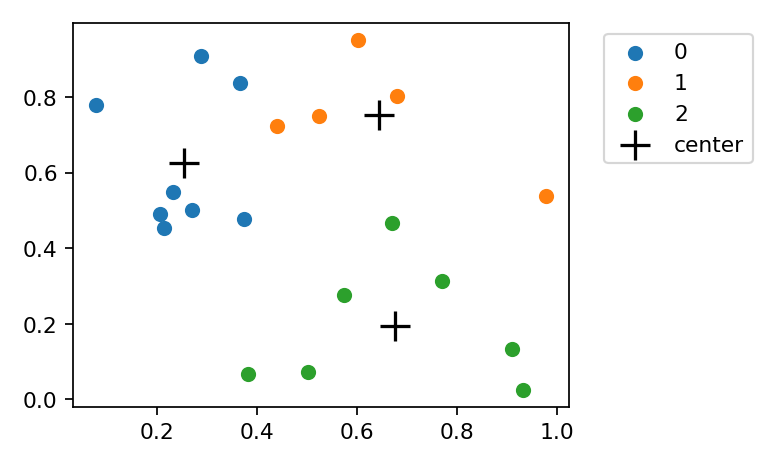

In [33]:
kmeans = KMeans(k=3)
kmeans.fit(X_toy, cycle_callback=callback)

%matplotlib inline

Voltaremos a esse tipo de plot novamente :D

## 1.2. (variante) k-Medians

Enquanto o k-Means utiliza a média dos pontos como protótipo dos clusters. Outra alternativa é utilizar a mediana como o "centro" de cada cluster. Isso tem o efeito de minimizar a norma Manhattan (1-norm), ao invés do quadrado da norma Euclidiana (2-norm), como no k-Means. Vamos aproveitar a nossa implementação do k-Means e mudar apenas o necessário:

In [34]:
class KMedians(KMeans):
    def _clustering_criterion(self, X, center):
        # Taxicab norm or Manhattan norm (1-norm)
        return np.sum(np.abs(X - center), axis=1)
    
    def _update_centers(self, X, verbose=False):
        scores = self.predict(X)
        
        new_centers = np.zeros_like(self.cluster_centers_)
        
        for center_id in range(self.k):
            # Aqui está a mudança!
            new_centers[center_id] = np.median(X[scores == center_id], axis=0)
        
        if verbose:
            print('\nMudança dos centros:')
            for center_id in range(self.k):
                print(f'{center_id}: {self.cluster_centers_[center_id]} -> {new_center[center_id]}')
                
        return new_centers

<IPython.core.display.Javascript object>


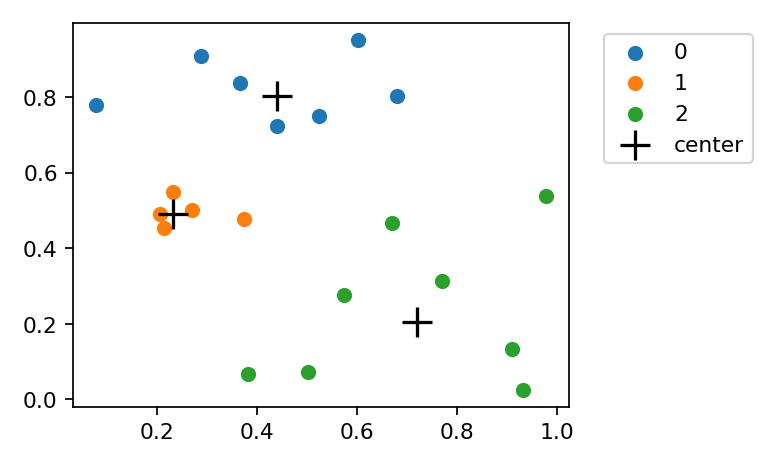

In [37]:
%matplotlib notebook
plt.ioff()

kmedians = KMedians(k=3, random_state=8)
kmedians.fit(X_toy, cycle_callback=callback)

%matplotlib inline

## 1.3 (variante) Partitioning Around Medoids (PAM) ou k-Medoids

O algoritmo PAM ou k-Medoids sempre utiliza pontos do próprio conjunto de dados como protótipo. Ele parte de um conjunto de *medoids* iniciais escolhidos aleatoriamente e funciona fazendo sucessivas substituições dos protótipos atuais por outros pontos que não são atualmente *medoids*, enquanto busca minimizar um função de distância. Aqui falamos diretamente em distância e, de fato, podemos usar qualquer métrica de distância com esse algorimo. Ao minimizar a distância total dos pontos para os medoids intuitivamente estamos escolhendo os "pontos mais centrais" nos clusters com os protótipos.

Um problema dessa abordagem de troca de *medoids* é o seu custo computacional.

In [38]:
class KMedoids(KMeans):
    def __init__(self, k, etol=1e-3, max_iter=100, random_state=42, p=1.5):
        super().__init__(k=k, etol=etol, max_iter=max_iter, random_state=random_state)
        self.p = p
    
    def _clustering_criterion(self, X, center):
        # Estou utilizando a distância Minkowski
        return np.sum((np.abs(X - center) ** self.p), axis=1) ** (1 / self.p)
    
    def _update_centers(self, X, verbose=False):
        best_cost = self._cost(X, self.cluster_centers_)
        
        # Inicio com os centros atuais
        new_centers = self.cluster_centers_.copy()
        
        # Variavel auxiliar
        aux_centers = self.cluster_centers_.copy()
        
        for center_id in range(self.k):
            # Aqui está a mudança!
            for x in X:
                # Se x já é medoid, pule
                if np.all(np.isclose(aux_centers[center_id] - x, 0.)):
                    continue
                aux_centers[center_id] = x
            
                new_cost = self._cost(X, aux_centers)

                if new_cost < best_cost:
                    best_cost = new_cost
                    new_centers[center_id] = x 
                else:
                    aux_centers[center_id] = new_centers[center_id]
        
        if verbose:
            print('\nMudança dos centros:')
            for center_id in range(self.k):
                print(f'{center_id}: {self.cluster_centers_[center_id]} -> {new_center[center_id]}')
                
        return new_centers
    
    def _cost(self, X, centers):
        # Matriz com n_instances x n_clusters
        errors = np.zeros((X.shape[0], self.k))
        
        for center_id, center in enumerate(centers):
            errors[:, center_id] = self._clustering_criterion(X, center)
        
        selected = np.argmin(errors, axis=1)
        
        return sum(sum(errors[selected == cluster_id, cluster_id]) for cluster_id in range(self.k))

<IPython.core.display.Javascript object>


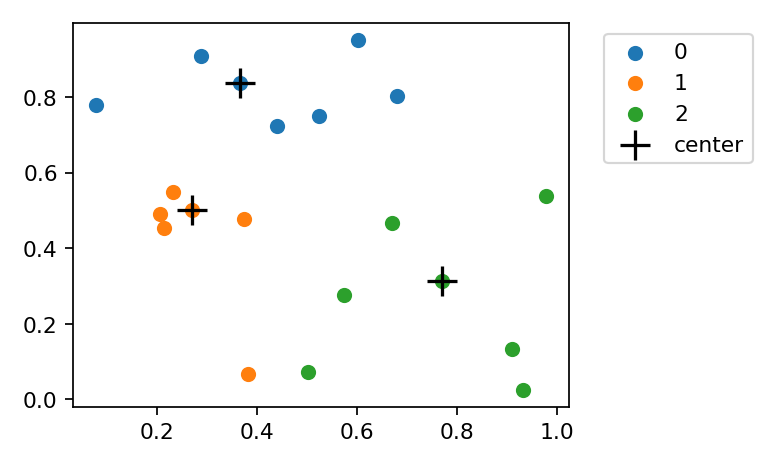

In [42]:
%matplotlib notebook
plt.ioff()

kmedoids = KMedoids(k=3, random_state=8)
kmedoids.fit(X_toy, cycle_callback=callback)

%matplotlib inline

## 1.3. Explorando casos mais interessantes

Vou gerar alguns exemplos extras para observarmos como os algoritmos de agrupamento se comportam.

### 1.3.1 Blobs

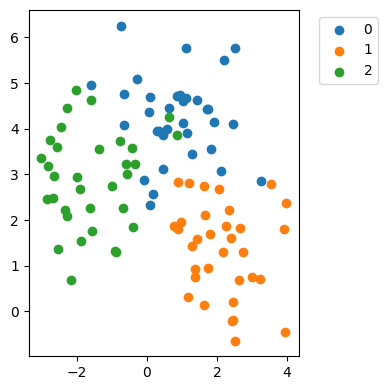

In [44]:
from sklearn import datasets

# Estamos usando y apenas para Taxicab norm or Manhattan norm para propósitos educativos. Nosso problema é não supervisionado
X_blob1, y_blob1 = datasets.make_blobs(n_samples=100, centers=3, n_features=2, random_state=0, cluster_std=1)

plot_cluster(X_blob1, y_blob1)

##### k-Means

<IPython.core.display.Javascript object>


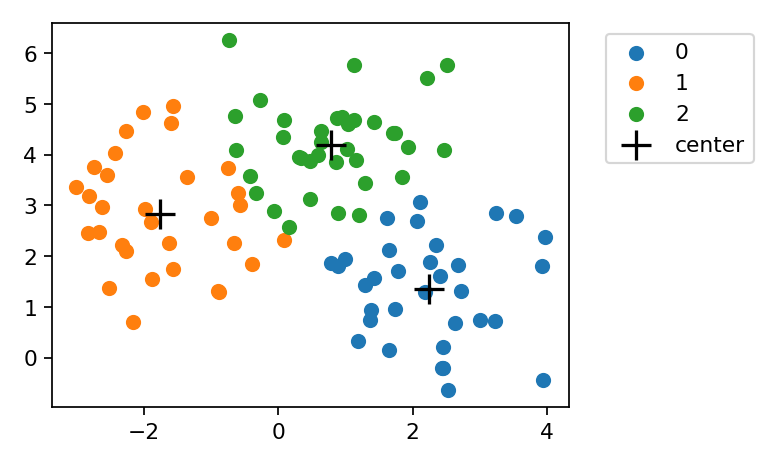

In [48]:
%matplotlib notebook
plt.ioff()

# Note que "sabemos o número de clusters"
kmeans_blob1 = KMeans(k=3, random_state=8)
kmeans_blob1.fit(X_blob1, cycle_callback=callback)

%matplotlib inline

##### k-Medians

<IPython.core.display.Javascript object>


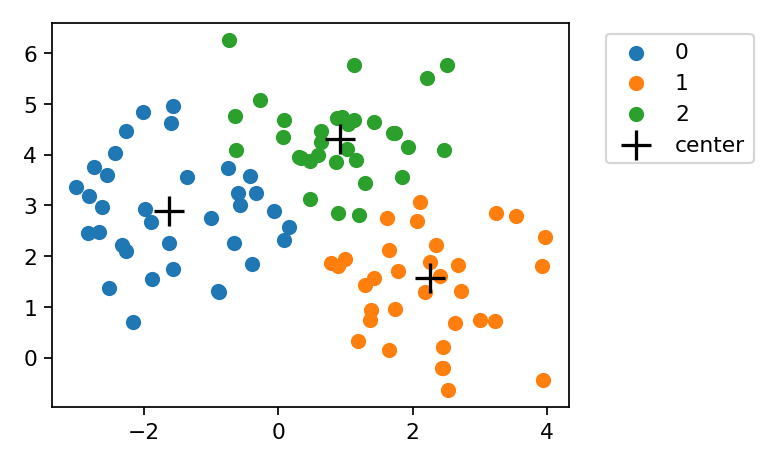

In [49]:
%matplotlib notebook
plt.ioff()

# Note que "sabemos o número de clusters"
kmedians_blob1 = KMedians(k=3, random_state=8)
kmedians_blob1.fit(X_blob1, cycle_callback=callback)

%matplotlib inline

##### k-Medoids

<IPython.core.display.Javascript object>


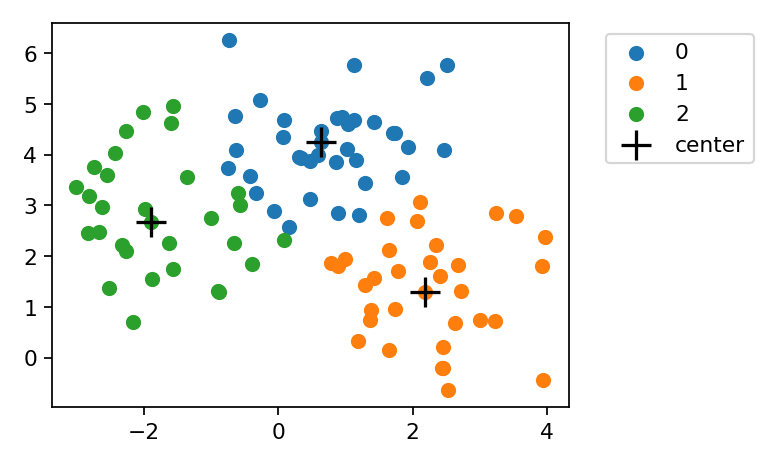

In [51]:
%matplotlib notebook
plt.ioff()

# Note que "sabemos o número de clusters"
kmedoids_blob1 = KMedoids(k=3, random_state=3)
kmedoids_blob1.fit(X_blob1, cycle_callback=callback)

%matplotlib inline

###### Vamos complicar um pouco as coisas

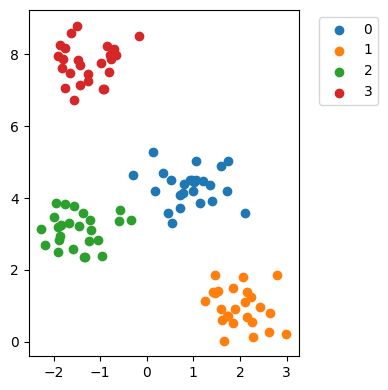

In [52]:
X_blob2, y_blob2 = datasets.make_blobs(n_samples=100, centers=4, n_features=2, random_state=0, cluster_std=0.5)

plot_cluster(X_blob2, y_blob2)

<IPython.core.display.Javascript object>


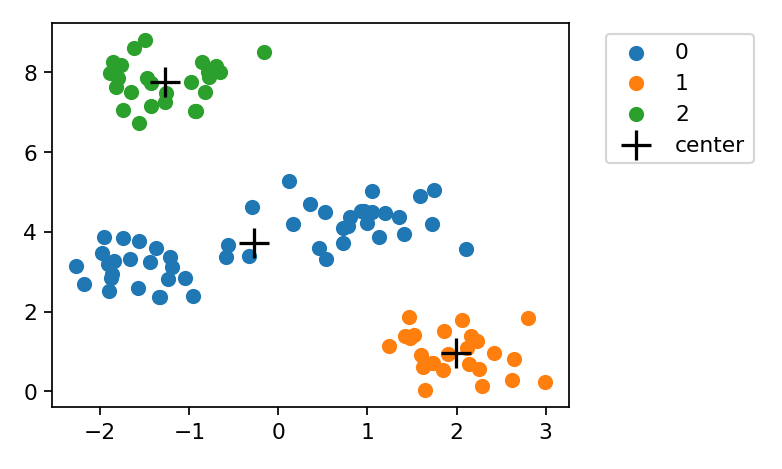

In [53]:
%matplotlib notebook
plt.ioff()

# Estou passando o número "errado" de clusters
kmeans_blob2 = KMeans(k=3, random_state=8)
kmeans_blob2.fit(X_blob2, cycle_callback=callback)

%matplotlib inline

O k-Means encontrará os três clusters, como pedimos. Ou quatro...

<IPython.core.display.Javascript object>


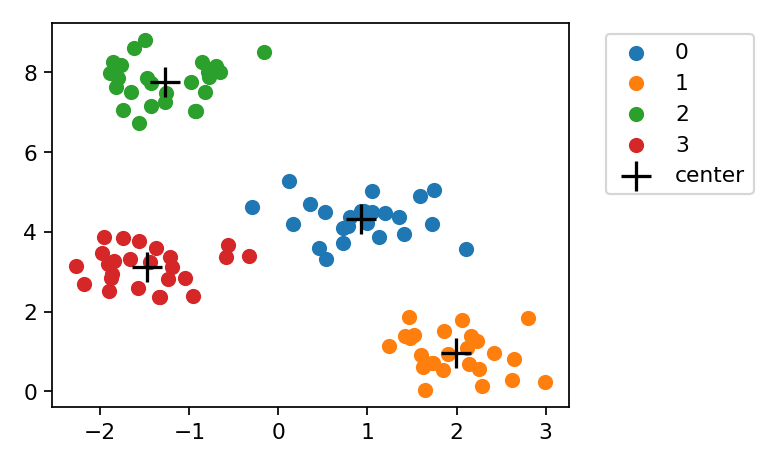

In [55]:
%matplotlib notebook
plt.ioff()

kmeans_blob2 = KMeans(k=4, random_state=8)
kmeans_blob2.fit(X_blob2, cycle_callback=callback)

%matplotlib inline

Ou dez!

<IPython.core.display.Javascript object>


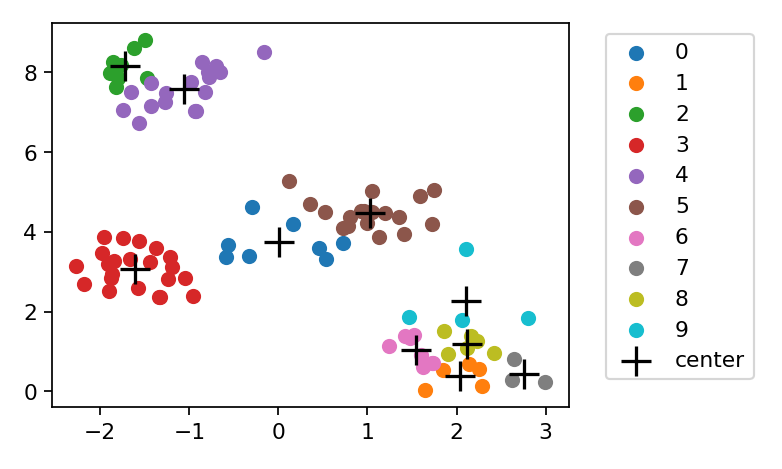

In [58]:
%matplotlib notebook
plt.ioff()

# Estou passando o número "errado" de clusters
kmeans_blob2 = KMeans(k=10, random_state=8)
kmeans_blob2.fit(X_blob2, cycle_callback=callback)

%matplotlib inline

### 1.3.2 Selecionando o número de clusters ([referência](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation))

Buscaremos avaliar as partições que encontramos utilizando métricas de avaliação.

#### 1.3.2.1 Caso não-supervisionado: Elbow method

É provavelmente uma das heurísticas mais conhecidas para a escolha do número de clusters no k-Means. Calculamos a soma das diferenças quadráticas de cada ponto para o centróide (*within cluster sum of squares* ou *inertia*) ao qual pertence e fazemos um plot variando o valor de `k`. Nesse gráfico procuramos pelo "ponto de cotovelo". No `sklearn` ela pode ser acessada utilizando `kmeans.inertia_`, onde `kmeans` é um modelo já treinado.

A equação da Inertia (inércia) ou é dada por:

$\text{Inertia} = \sum_{c \in C} \sum_{x \in c} (x - \overline{c})^2$, onde $C$ é o conjunto de todos os clusters e $\overline{c}$ é o centróide do cluster $c$.

Nós a implementaremos aqui utilizando métodos do nosso modelo kmeans treinado. Se estiver utilizando o k-Means do `sklearn` substitua essa função pela propriedade `inertia_` do `KMeans`.

In [59]:
def sum_inertia(X, kmeans):
    scores = kmeans.predict(X)
    
    sum_inertia = 0.
    for cluster_id in np.unique(scores):
        imask = scores == cluster_id
        sum_inertia += np.sum(
            kmeans._clustering_criterion(X[imask], kmeans.cluster_centers_[cluster_id]))
    
    return sum_inertia

In [60]:
# Primeiro dataset
inertia_scores = []
for k in range(2, 10):
    kmeans = KMeans(k=k, random_state=8)
    kmeans.fit(X_blob1)
    inertia_scores.append(sum_inertia(X_blob1, kmeans))

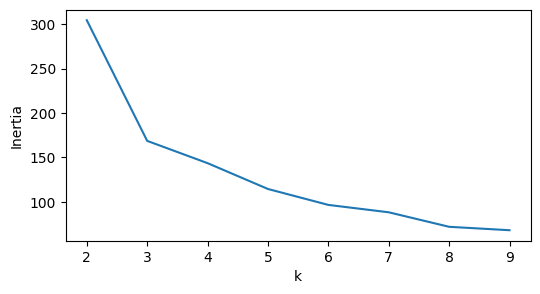

In [62]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(range(2, 10), inertia_scores)
ax.set_xlabel('k')
ax.set_ylabel('Inertia')
plt.show()

O "cotovelo" está em `k=3`, como esperado.

In [63]:
# Segundo dataset
inertia_scores = []
for k in range(2, 10):
    kmeans = KMeans(k=k, random_state=8)
    kmeans.fit(X_blob2)
    inertia_scores.append(sum_inertia(X_blob2, kmeans))

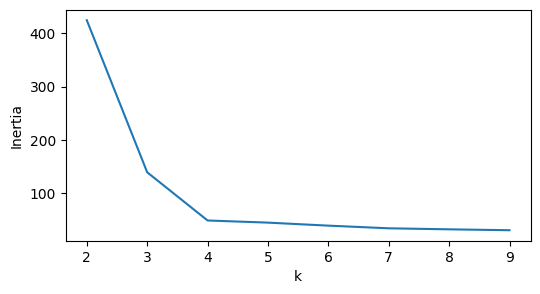

In [64]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(range(2, 10), inertia_scores)
ax.set_xlabel('k')
ax.set_ylabel('Inertia')
plt.show()

Aqui, a mudança mais brusca (cotovelo) ocorre em `k=4`.

#### 1.3.2.2 Caso não supervisionado: silhueta (silhouette)

Uma forma simples de estimarmos o número de clusters é avaliarmos valores crescentes de `k` plotarmos os valores de silhueta obtidos. A nossa medida aqui é a silhueta que varia entre $[-1, 1]$, sendo $1$ o melhor valor possível. Essa métrica avalia a densidade das partições encontradas.

- **Vantagens silhueta**
   - Métrica em intervalo bem definido: de -1 (ruim), passando por 0 (clusters com *overlap*), até 1 (bom)
   - Os valores são altos quando os clusters são densos e bem separados, o que está intimamente ligado à noção usual de agrupamento.
- **Desvantagem**
    - O k-Means cria estruturas convexas, de fato, estruturas similares à hiper-esferas (ou uma gaussiana multivariada). Essa métrica favorece esse tipo de estrutura. Clusters encontrados por outras estratégias de particionamento, como o agrupamento por densidade, tendem a obter menores valores de silhueta (e nem por isso são piores).


In [65]:
from sklearn.metrics import silhouette_score

# Primeiro dataset
silh_scores = []
for k in range(2, 10):
    kmeans = KMeans(k=k, random_state=8)
    kmeans.fit(X_blob1)
    silh_scores.append(silhouette_score(X_blob1, kmeans.predict(X_blob1)))

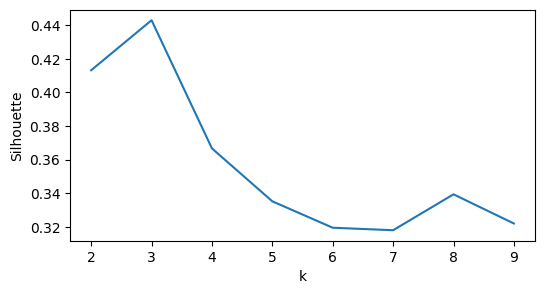

In [67]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(range(2, 10), silh_scores)
ax.set_xlabel('k')
ax.set_ylabel('Silhouette')
plt.show()

In [68]:
# Segundo dataset
silh_scores = []
for k in range(2, 10):
    kmeans = KMeans(k=k, random_state=8)
    kmeans.fit(X_blob2)
    silh_scores.append(silhouette_score(X_blob2, kmeans.predict(X_blob2)))

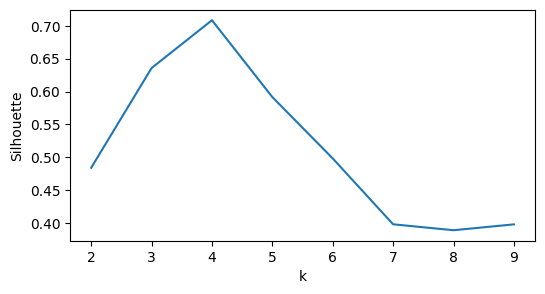

In [69]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(range(2, 10), silh_scores)
ax.set_xlabel('k')
ax.set_ylabel('Silhouette')
plt.show()

Escolhemos o ponto que maximiza a silhueta média (`k=3` e `k=4` para o primeiro e segundo casos, respectivamente).

Devemos lembrar que a silhueta é definida para cada ponto. Até agora consideramos apenas valores médios.

##### Abordagem mais geral

Utilizarei uma outra abordagem, sugerida pelo `sklearn`, baseada em [silhouette analysis](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html). Esta abordagem considera tanto a silhueta média, como a silhueta de cada ponto.

Definirei uma função de plot extra:

In [70]:
from sklearn.metrics import silhouette_score, silhouette_samples

import matplotlib.pyplot as plt
import matplotlib.cm as cm


def plot_silhouettes(X, k, random_state=42):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_xlim([-1, 1])

    # Use esta linha para a implementação didática
    clusterer = KMeans(k=k, random_state=random_state)
    # Use essa linha se estiver usando a versão do sklearn
    # clusterer = KMeans(n_clusters=k, random_state=random_state)

    clusterer.fit(X)
    cluster_labels = clusterer.predict(X)

    # Silhueta para cada ponto
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    
    # Silhueta média
    silhouette_avg = silhouette_score(X, cluster_labels)
    
    y_lower = 10  # Padding
    for i in range(k):
        # Seleciona as silhuetas de cada cluster e as ordena
        cluster_silh = sample_silhouette_values[cluster_labels == i]
        cluster_silh.sort()

        size_cluster = len(cluster_silh)
        y_upper = y_lower + size_cluster

        color = cm.nipy_spectral(float(i) / k)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                         0, cluster_silh, facecolor=color,
                         edgecolor=color, alpha=0.7)

        # Nome dos clusters
        ax.text(-0.05, y_lower + 0.5 * size_cluster, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title(f'k={k}')
    ax.set_xlabel('Silhueta')
    ax.set_ylabel('Cluster')

    # Linha vertical indicando a silhueta média
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    ax.set_yticks([])

**O que devemos observar nesse plot:**

1. O eixo x apresenta os valores de silhueta
2. Os clusters são apresentados de forma separada
3. Para cada cluster, as instâncias que a eles pertecem estão ordenadas pelos seus valores individuais de silhueta
4. A silhueta média é indicada pela linha vertical (serrilhada) vermelha

**Como escolher `k` a partir desse plot?**
1. Queremos que a largura das barras (variação no eixo `y`) sejam similares.
2. Queremos que os comprimentos das barras estejam acima ou próximas do valor de silhueta médio (nunca abaixo).
3. Queremos um valor de `k` que não acarrete flutuações nos comprimentos (todas as barras com comprimentos similares).
4. Não queremos silhuetas negativas!

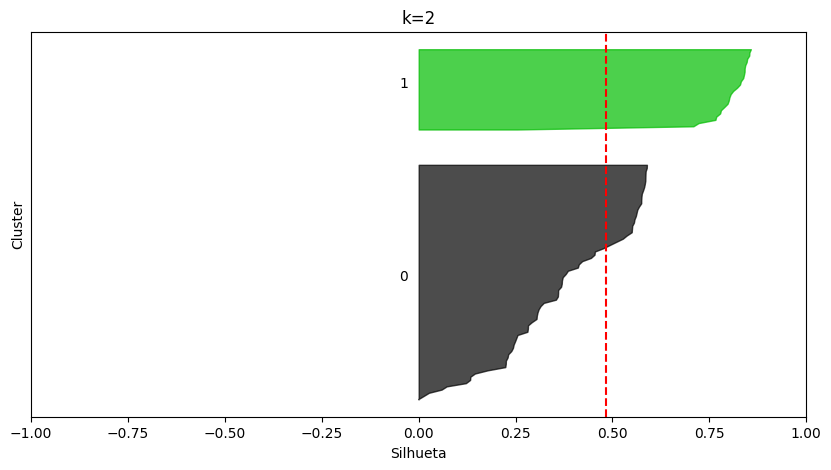

In [71]:
plot_silhouettes(X_blob2, 2, random_state=8)

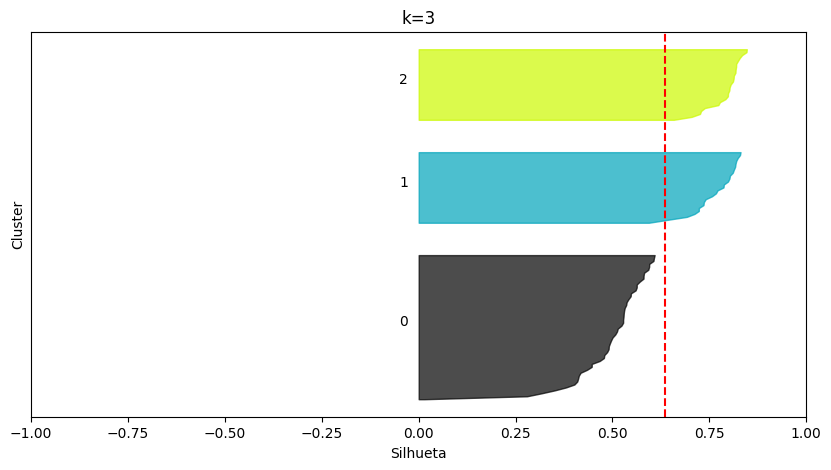

In [72]:
plot_silhouettes(X_blob2, 3, random_state=8)

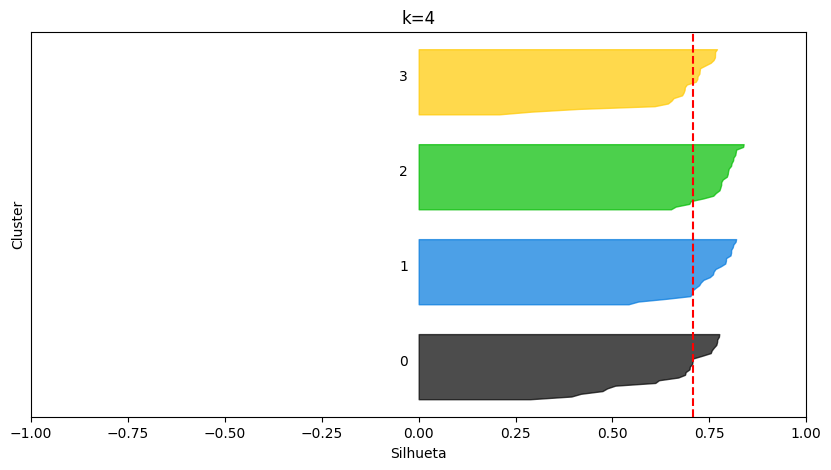

In [73]:
plot_silhouettes(X_blob2, 4, random_state=8)

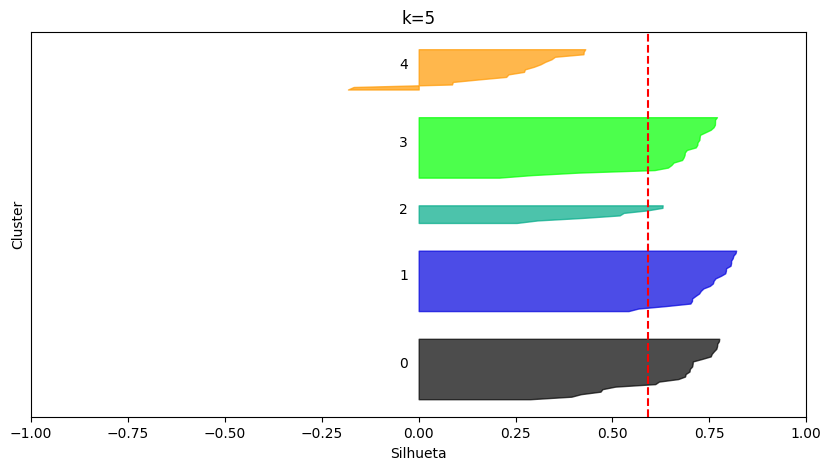

In [74]:
plot_silhouettes(X_blob2, 5, random_state=8)

O nosso vencedor foi `k=4`, como esperado.

**Atenção:** notem como eu usei uma random seed diferente. Em nossa implementação, utilizamos apenas uma inicialização aleatória dos centroides. Como eu já mencionei, existem formas mais "espertas" de se fazer isso. Tais estratégias fazem toda a diferença! Além disso, o `sklearn` prevê também utilizar várias inicializações e escolher qual delas for a melhor (isso é um hiperparâmetro).

**"Tarefa":** quem tiver curiosidade, experimente mudar os `random_state` nos gráficos anteriores e nos próximos para observar o impacto.

#### 1.3.2.3 Caso supervisionado: Adjusted Rand Index

In [75]:
from sklearn.metrics import adjusted_rand_score

# Primeiro dataset
rand_scores = []
for k in range(2, 10):
    kmeans = KMeans(k=k, random_state=8)
    kmeans.fit(X_blob1)
    rand_scores.append(adjusted_rand_score(y_blob1, kmeans.predict(X_blob1)))

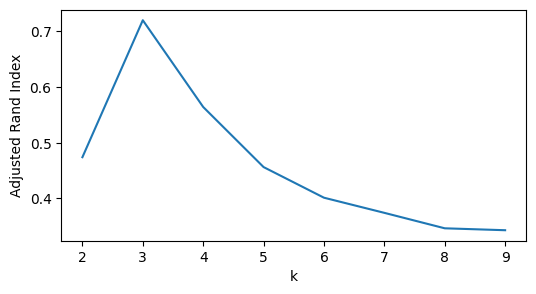

In [76]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(range(2, 10), rand_scores)
ax.set_xlabel('k')
ax.set_ylabel('Adjusted Rand Index')
plt.show()

In [79]:
# Segundo dataset
rand_scores = []
for k in range(2, 10):
    kmeans = KMeans(k=k, random_state=8)
    kmeans.fit(X_blob2)
    rand_scores.append(adjusted_rand_score(y_blob2, kmeans.predict(X_blob2)))

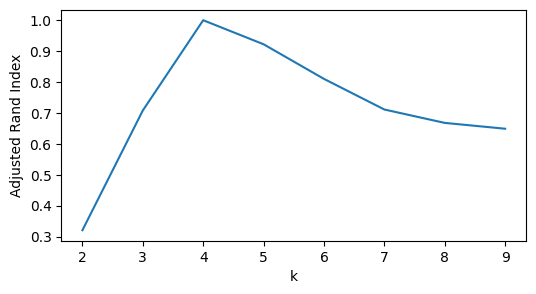

In [80]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(range(2, 10), rand_scores)
ax.set_xlabel('k')
ax.set_ylabel('Adjusted Rand Index')
plt.show()

**Vantagens do _Adjusted Rand Index_ (ARI)**:
- Predição aleatória origina um valor de ARI próximo de zero
- Ranges bem definidos: $[-1, 1]$
    - $-1$ é ruim
    - $0$ é a predição aleatória
    - $1$ é o melhor valor possível
- Ignora permutações
- É simétrica `ARI(A, B) == ARI(B, A)`
- Não assume nada sobre a estrutura dos clusters

**Desvantagem:**
- Supervisionada, o que não é realístico na maioria dos casos

### 1.3.3. Nem tudo são flores: dataset Circles

In [ ]:
X_circ1, y_circ1 = datasets.make_circles(n_samples=500, noise=0.05, random_state=8, factor=0.1)

plot_cluster(X_circ1, y_circ1)

Dois clusters! Sopinha de algodão, certo? Vamos ver

In [ ]:
%matplotlib notebook
plt.ioff()

kmeans_circ1 = KMeans(k=2, random_state=8)
kmeans_circ1.fit(X_circ1, cycle_callback=callback)

%matplotlib inline

In [ ]:
%matplotlib notebook
plt.ioff()

kmeans_circ1 = KMeans(k=2, random_state=1)
kmeans_circ1.fit(X_circ1, cycle_callback=callback)

%matplotlib inline

In [ ]:
%matplotlib notebook
plt.ioff()

kmeans_circ1 = KMeans(k=2, random_state=3)
kmeans_circ1.fit(X_circ1, cycle_callback=callback)

%matplotlib inline

E agora? Uma saída poderia ser aumentar o número de clusters e contar com um especialista humano para nos dizer que múltiplos grupos representam um mesmo conceito:

In [ ]:
%matplotlib notebook
plt.ioff()

kmeans_circ1 = KMeans(k=5, random_state=8)
kmeans_circ1.fit(X_circ1, cycle_callback=callback)

%matplotlib inline

Nesse caso, e para essa seed aleatória (e apenas uma inicialização) temos que os clusters $k \in \{0, 2, 3, 4\}$ representam o mesmo "conceito", i.e., o círculo externo. Nós sabemos isso porque nossos dados estão em duas dimensões e foram gerados artificialmente.

In [ ]:
plot_silhouettes(X_circ1, 2, random_state=8)

In [ ]:
plot_silhouettes(X_circ1, 5, random_state=8)

In [ ]:
plot_silhouettes(X_circ1, 10, random_state=8)

In [ ]:
%matplotlib notebook
plt.ioff()

kmeans_circ1 = KMeans(k=10, random_state=8)
kmeans_circ1.fit(X_circ1, cycle_callback=callback)

%matplotlib inline

Percebemos que apesar de `k=5` responder bem ao nosso problema, como observado empiricamente, a silhueta está privilegiando estruturas (hiper-esféricas) circulares e densas, como previamente discutido. Por essa razão $k=10$ poderia ser uma escolha boa segundo os critérios previamente discutidos.

O problema vai mais longe... E se a estrutura fosse mais dúbia?

In [ ]:
X_circ2, y_circ2 = datasets.make_circles(n_samples=500, noise=0.05, random_state=8, factor=0.7)

plot_cluster(X_circ2, y_circ2)

In [ ]:
%matplotlib notebook
plt.ioff()

# k-Means
kmeans_circ2 = KMeans(k=5, random_state=8)
kmeans_circ2.fit(X_circ2, cycle_callback=callback)

%matplotlib inline

In [ ]:
%matplotlib notebook
plt.ioff()

# k-Medians
kmedians_circ2 = KMedians(k=5, random_state=8)
kmedians_circ2.fit(X_circ2, cycle_callback=callback)

%matplotlib inline

É, agora complicou o meio de campo. :P

E esse é apenas um dos exemplos. Podemos manter o padrão da primeira variante desse dataset com a adição de ruído para perceber um outro problema nesse tipo de abordagem.

In [ ]:
X_circ3, y_circ3 = datasets.make_circles(n_samples=500, noise=0.15, random_state=8, factor=0.3)

# Vou até acelerar os plots:
callback = plot_callback_factory(0.1)

plot_cluster(X_circ3, y_circ3)

In [ ]:
%matplotlib notebook
plt.ioff()

# k-Means
kmeans_circ3 = KMeans(k=2, random_state=8)
kmeans_circ3.fit(X_circ3, cycle_callback=callback)

%matplotlib inline

In [ ]:
%matplotlib notebook
plt.ioff()

# k-Means
kmeans_circ3 = KMeans(k=3, random_state=8)
kmeans_circ3.fit(X_circ3, cycle_callback=callback)

%matplotlib inline

In [ ]:
%matplotlib notebook
plt.ioff()

# k-Means
kmeans_circ3 = KMeans(k=5, random_state=8)
kmeans_circ3.fit(X_circ3, cycle_callback=callback)

%matplotlib inline

In [ ]:
%matplotlib notebook
plt.ioff()

# k-Means
kmeans_circ3 = KMeans(k=10, random_state=8)
kmeans_circ3.fit(X_circ3, cycle_callback=callback)

%matplotlib inline

### 1.3.4 Moons

In [ ]:
X_moons1, y_moons1 = datasets.make_moons(random_state=8, noise=0.05)

plot_cluster(X_moons1, y_moons1)

In [ ]:
%matplotlib notebook
plt.ioff()

# k-Means
kmeans_moons1 = KMeans(k=2, random_state=8)
kmeans_moons1.fit(X_moons1, cycle_callback=callback)

%matplotlib inline

In [ ]:
%matplotlib notebook
plt.ioff()

# k-Means
kmeans_moons1 = KMeans(k=5, random_state=8)
kmeans_moons1.fit(X_moons1, cycle_callback=callback)

%matplotlib inline

In [ ]:
plot_silhouettes(X_moons1, 2, random_state=8)

In [ ]:
kmeans_moons1 = KMeans(k=2, random_state=8)
kmeans_moons1.fit(X_moons1)
adjusted_rand_score(y_moons1, kmeans_moons1.predict(X_moons1))

In [ ]:
plot_silhouettes(X_moons1, 3, random_state=8)

In [ ]:
kmeans_moons1 = KMeans(k=3, random_state=8)
kmeans_moons1.fit(X_moons1)
adjusted_rand_score(y_moons1, kmeans_moons1.predict(X_moons1))

In [ ]:
plot_silhouettes(X_moons1, 5, random_state=8)

In [ ]:
kmeans_moons1 = KMeans(k=5, random_state=8)
kmeans_moons1.fit(X_moons1)
adjusted_rand_score(y_moons1, kmeans_moons1.predict(X_moons1))

**Houston we have a problem!**

O víes de aprendizado dos algorítmos baseados em protótipos não é adequado para esses problemas cujos clusters não são convexos e nem hiper-esféricos. De fato, o k-Means pode ser visto como um caso especial de *Gaussian Mixture models*. Se abstrairmos um pouco, o que estamos fazendo é posicionar funções gaussianas multivariadas nos dados. A média dessas gaussianas é justamente os centróides. Cool, huh?

Avaliaremos um outro tipo de agrupamento particional para tentar resolver esse problema específico.


**Mas calma!** Não é o fim da linha para o nosso amigo k-Means. Deixo aqui esse [post](https://pafnuty.wordpress.com/2013/08/14/non-convex-sets-with-k-means-and-hierarchical-clustering/) que achei muito interessante. O autor demonstra como podemos combinar agrupamento hierárquico (outra classe de algoritmos de agrupamento) com o k-Means para lidar com problemas não-convexos. Uma ideia que de certa forma se assemelha com o que o [HDBSCAN](https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html) (o novo algoritmo queridinho do momento) faz para criar os grupos!

# 2. Clustering particional: densidade

*Density-based spatial clustering of applications with noise* [(DBSCAN)](https://scikit-learn.org/stable/modules/clustering.html#dbscan) é um algoritmo para agrupamento de dados que funciona de forma diferente das abordagens que vimos até agora. O DBSCAN não assume nada sobre as estruturas dos clusters nos dados. De fato, para o DBSCAN, clusters são regiões de alta densidade separadas por regiões de baixa densidade, não importando a sua forma. Além disso, prevê a existência de pontos que não pertencem a nenhum dos clusters, em outras palavras, *outliers*.

O DBSCAN parte dos seguintes pressupostos principais:

- *Core points*: são pontos em regiões de alta densidade;
- *Border points*: pontos "acessíveis" através de um *core* point, mas que não são *core points*.
- *Noise/Outlier*: pontos que não são acessíveis por um ponto *core*.

O DBSCAN possui dois hiper-parâmetros:

- `eps`: define um raio de vizinhança, em outras palavras, um ponto $p$ está conectado a outro ponto $q$ se $d(p, q) \le \epsilon$, onde $d$ é uma função de distância (aqui não assumimos nada sobre a métrica de distância utilizada).
- `min_samples`: define quantos pontos devem estar na `eps`-vizinhança de um ponto, para que tal ponto seja considerado *core*.

No entanto, o DBSCAN tem problemas com datasets que possuem muitas variações em densidade e são esparsos. Se os clusters possuem diferentes densidades não será possível se encontrar uma boa combinação de `eps` e `min_samples`.

In [ ]:
from sklearn.neighbors import KDTree

class DBSCAN:
    def __init__(self, eps=0.5, min_samples=4, p=2):
        self.eps = eps
        self.min_samples = min_samples
        self.p = p  # Distância Minkowski
    
    def _minkowski_distance(self, x1, x2):
        return np.sum(np.abs(x1 - x2) ** self.p, axis=1) ** (1 / self.p)
    
    def fit(self, X, cycle_callback=None):
        # Plot inicial vazio
        p_out = None
        
        # Indices na base dados
        indices = np.array(range(X.shape[0]))

        # O label de todos os pontos é indefinido
        self.labels_ = np.full(X.shape[0], -999)
        
        # Faz primeiro plot
        if cycle_callback is not None:
            p_out = cycle_callback(X, self.labels_, fig=p_out)
        
        # Core samples
        self.core_sample_indices_ = set()
        
        # Estrutura para buscar vizinhos mais próximos
        kdtree = KDTree(X, p=self.p)

        c = 0  # Id do cluster
        for i in range(X.shape[0]):
            # Já é core point, ponto de borda ou outlier
            if self.labels_[i] != -999:
                continue
            
            # Todos os vizinhos de X_i, com ele incluso no raio eps
            neighbors = kdtree.query_radius(X[i].reshape(1, -1), r=self.eps)[0]
            
            if len(neighbors) < self.min_samples: # Não é denso o suficiente
                self.labels_[i] = -1  # Noise ou outlier
                
                # Atualiza plot
                if cycle_callback is not None:
                    p_out = cycle_callback(X, self.labels_, fig=p_out)
                continue
            
            self.core_sample_indices_.add(i)
            self.labels_[i] = c
            
            # Atualiza plot
            if cycle_callback is not None:
                p_out = cycle_callback(X, self.labels_, fig=p_out)
            
            # Remove X_i de sua própria vizinhança e define conjunto para expansão
            seed_set = neighbors[neighbors != i].tolist()
            
            # Agora expandiremos a vizinhança do nosso ponto p
            for j in seed_set:
                if self.labels_[j] == -1:  # É ruido (até agora)
                    self.labels_[j] = c  # Muda ponto previamente considerado ruído
                    # Atualiza plot
                    if cycle_callback is not None:
                        p_out = cycle_callback(X, self.labels_, fig=p_out)
                
                if self.labels_[j] != -999:
                    continue  # Ponto já foi processado
                
                self.labels_[j] = c

                # Atualiza plot
                if cycle_callback is not None:
                    p_out = cycle_callback(X, self.labels_, fig=p_out)
                
                # Vamos procurar mais pontos que podem ser acessados por esse elemento
                # conectado ao nosso core point
                neighbors = kdtree.query_radius(X[j].reshape(1, -1), r=self.eps)[0]
                
                if len(neighbors) >= self.min_samples:  # Também é um core point
                    seed_set.extend(neighbors.tolist())  # Adiciona pontos para o seed set
                    self.core_sample_indices_.add(j)
            
            c += 1 # Vamos para o próximo cluster!
        
        # Converte para array do numpy (só para ficar parecido com o sklearn)
        self.core_sample_indices_ = np.array(list(self.core_sample_indices_))
        
        # Vou salvar os core points (só para ficar igual ao sklearn também)
        self.components_ = np.zeros((len(self.core_sample_indices_), X.shape[1]))
        for i, core_p in enumerate(self.core_sample_indices_):
            self.components_[i] = X[core_p]
        
        return self
    
    def fit_predict(self, X):
        self.fit(X)
        
        return self.labels_

**Criarei um função diferente para plot, visto as diferenças do algoritmo de clustering**

In [ ]:
def dbscan_plot_callback_factory(delay=0.2):
    # Recicla plots para simular animações
    def plot_at_each_cycle(X, labels, fig=None, delay=delay):
        if fig is not None:
            fig.axes[0].clear()
            ax = fig.axes[0]
        else:
            fig, ax = plt.subplots(figsize=(5, 3))
        
        label_transformer = lambda x: (f'Cluster {x}' if x >= 0 else 'Noise') \
            if x >= -1 else 'Indefinido'
        marker_transformer = lambda x: ('o' if x >= 0 else 'x') if x >= -1 else '.'
        
        # Transforma cluster label em valor que pode mapeado (estou supondo no max 15 clusters)
        c_normalizer = matplotlib.colors.Normalize(vmin=0., vmax=15)
        cmap = matplotlib.colormaps['hsv']

        color_transformer = lambda x: ((.5, .5, .5, 1.) if x == -999 else (0., 0., 0., 1.)) \
            if x < 0 else cmap(c_normalizer(x))

        for label in np.unique(labels):
            imask = labels == label
            colors = [color_transformer(label) for _ in range(np.sum(imask))]
            ax.scatter(X[imask, 0], X[imask, 1], label=label_transformer(label),
                       marker=marker_transformer(label), c=colors)

        ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
        plt.tight_layout()
        plt.close()
        # Exibe os resultados
        fig.show()
        fig.canvas.draw()
        time.sleep(delay)
        
        return fig
    
    return plot_at_each_cycle

Função callback para plot

In [ ]:
dbscan_callback = dbscan_plot_callback_factory(0.2)

##### DBSCAN com valores default

In [ ]:
%matplotlib notebook
plt.ioff()

dbscan = DBSCAN()
dbscan.fit(X_toy, cycle_callback=dbscan_callback)

%matplotlib inline

Não deu muito certo. Precisamos ter em mente características dos nossos dados (notem que os ranges dessa base são entre 0 e 1). Vamos tentar outros valores:

In [ ]:
%matplotlib notebook
plt.ioff()

dbscan = DBSCAN(eps=0.2)
dbscan.fit(X_toy, cycle_callback=dbscan_callback)

%matplotlib inline

Que tal esses?

In [ ]:
%matplotlib notebook
plt.ioff()

dbscan = DBSCAN(eps=0.25)
dbscan.fit(X_toy, cycle_callback=dbscan_callback)

%matplotlib inline

##### Dataset blob

In [ ]:
dbscan_callback = dbscan_plot_callback_factory(0.)

In [ ]:
%matplotlib notebook
plt.ioff()

dbscan = DBSCAN()
dbscan.fit(X_blob1, cycle_callback=dbscan_callback)

%matplotlib inline

Let's try again

In [ ]:
%matplotlib notebook
plt.ioff()

dbscan = DBSCAN(min_samples=3)
dbscan.fit(X_blob1, cycle_callback=dbscan_callback)

%matplotlib inline

Vamos tentar a outra variação que criamos para esse dataset

In [ ]:
%matplotlib notebook
plt.ioff()

dbscan = DBSCAN()
dbscan.fit(X_blob2, cycle_callback=dbscan_callback)

%matplotlib inline

Está melhor.

Vamos supor que nesse dataset nós esperaramos encontrar quatro grupos (sabemos as características do problema) e estamos percebendo muitos ruídos. Podemos tentar aumentar o valor de `eps`:

In [ ]:
%matplotlib notebook
plt.ioff()

dbscan = DBSCAN(eps=0.7)
dbscan.fit(X_blob2, cycle_callback=dbscan_callback)

%matplotlib inline

 A escolha de hiperparâmetros parece uma tarefa um pouco mais complicada nesse caso (e ainda temos o auxilio das visualizações). Escolher o `k` do k-Means foi muito mais fácil nesses casos!

## 2.1 Usando o DBSCAN em geometrias não-convexas

Como será que o DBSCAN se sai nos casos onde o k-Means teve suas dificuldades?

In [ ]:
%matplotlib notebook
plt.ioff()

dbscan = DBSCAN()
dbscan.fit(X_circ1, cycle_callback=dbscan_callback)

%matplotlib inline

In [ ]:
%matplotlib notebook
plt.ioff()

dbscan = DBSCAN(eps=0.15, p=1, min_samples=6)
dbscan.fit(X_circ2, cycle_callback=dbscan_callback)

%matplotlib inline

(variei muito os hiperparâmetros até chegar nisso)

In [ ]:
%matplotlib notebook
plt.ioff()

from sklearn.preprocessing import StandardScaler

dbscan = DBSCAN()
dbscan.fit(StandardScaler().fit_transform(X_moons1), cycle_callback=dbscan_callback)

%matplotlib inline

No fim das contas, tudo é uma questão de boas escolhas :D


## 2.2 Como escolher os valores de `eps` e `min_samples`

Essa não é uma resposta trivial. Recentemente, os autores do algoritmo publicaram um [artigo](https://www.ccs.neu.edu/home/vip/teach/DMcourse/2_cluster_EM_mixt/notes_slides/revisitofrevisitDBSCAN.pdf) revisitando vários pontos do DBSCAN e discutem algumas possíveis formas de se escolher os seus parâmetros.

- `min_samples`: uma *"thumb rule"* para selecionar esse hiper-parâmetro é `2 * n_features`. Notem que o valor padrão é `4` e estamos utilizando exemplos bi-dimensionais. No entanto, para datasets muito grandes, com muitas features, ou com muito ruído, é uma boa ideia mudar os valores desse parâmetro.
- `eps`: esse hiper-parâmetro é mais complicado de ser ajustado e também depende da função de distância utilizada. Idealmente ele deve ser o menor possível e deveria ser ajustado com base em um especialista do domínio. Por exemplo, se estamos agrupando dados de GPS, um especialista poderia nos dizer que a distância de 1km deveria ligar dois pontos. Nesse caso, pode ser válido ajustar também o valor de `min_samples`. Os autores do DBSCAN aconselham deixar um dos hiper-parâmetros livres. Existem heurísticas parecidas com a do "cotovelo", mas não são tão triviais como no caso do k-Means.

Em geral, ao explorarmos valores de hiper-parâmetros:
- Não queremos que muitos pontos sejam marcados como ruído:
    - Os autores do DBSCAN afirmam que um valor adequado de instâncias identificadas como ruído está entre $1\%$ e $30\%$
- Se o maior componente (cluster) tem muitos dados (entre $20\%$ até $50\%$), isso pode ser um indício de que o valor de `eps` escolhido está muito alto. Nesse caso, os autores apontam dois caminhos:

    - Diminuir o valor de `eps`
    - Utilizar uma abordagem modificada do DBSCAN que utilizam hierarquias: OPTICS e HDBSCAN.
    
A [seção de clustering](https://scikit-learn.org/stable/modules/clustering.html) do sklearn apresenta vários algoritmos de agrupamento que estão disponíveis, assim como métricas de avaliação, dicas e comparações entre os clusterizadores. Existe, inclusive, uma [tabela comparativa](https://scikit-learn.org/stable/modules/clustering.html#overview-of-clustering-methods) dos algorítmos disponíveis apontando casos de uso. Recomendo também a seção 4 do artigo que mencionei anteriormente, dos próprios autores do DBSCAN.

Por fim, o HDBSCAN (deixei um link para a sua biblioteca anteriormente) é uma evolução do DBSCAN e corrige muitas de suas falhas! Em geral, o HDBSCAN possui apenas um parâmetro extremamente crucial, que pode ser mais intuitivamente ajustado! Recomendo muito verificar!

# 3. Relembrando as diferenças

- Protótipos vs Densidade
    - O k-Means e similares utilizam uma noção de um centro, ou ponto representativo do grupo
    - O DBSCAN não possui tais noções. Os pontos *core* não definem um protótipo para o grupo: um mesmo cluster pode possuir vários pontos *core*.

- Número de clusters
    - O número é pré-definido no k-Means
        - Porém existem várias estratégias para se encontrar valores adequados de k
        - Os grupos encontrados são hiper-esféricos
    - O número é encontrado automaticamente no DBSCAN
        - No entanto, encontrar valores para o seus hiper-parâmetros não é trivial
        - Nada é assumido acerca da forma dos grupos

- Ruídos e outliers
    - O k-Means é sensível a ruídos e outliers (esses tipo de dados podem deslocar os centros)
    - O DBSCAN prevê a existência de ruídos nos dados (o algorítmo deve estar bem ajustado para que funcione bem)

- Inicialização
    - O resultado do k-Means depende de sua inicialização
    - O DBSCAN  é determinístico

# Tarefa

1. Discutimos em aula que o DBSCAN é determinístico, visto que todos os pontos são visitados. O que acontece se os dados de entrada forem embaralhados (qual é o impacto dessa ação nos grupos)?

**R:**

2. Descreva, com suas palavras, as diferenças dentre o k-NN e o k-Means considerando o propósito de aplicação de cada um.

**R:**

### Para uso em emergências:

Executa as porções essenciais do código caso algum problema ocorra. Evita que seja necessário rodar todas as animações sequencialmente.

In [ ]:
%%javascript
Jupyter.notebook.execute_cells([1, 2, 4, 6, 8, 38, 41, 45, 48, 51, 59, 66, 74, 79, 87,
                                93, 106, 110, 116, 127, 129, 139])